In [1]:
from mfbml.methods.mfrbfgp import MFRBFGPR
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from mfpml.design_of_experiment.multifidelity_samplers import MFSobolSequence
from mfpml.models.gaussian_process import GaussianProcess
from mfpml.models.kernels import RBF
from mfpml.problems.multifidelity_functions import (
    Forrester_1c,
    Forrester_1a,
    Forrester_1b,
)
import time
from scipy.linalg import cholesky, solve
from scipy.optimize import minimize

# import accuracy measures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
def calculate_log_marginal_likelihood_mf(model: MFRBFGPR, sample_x, sample_y):
    # get test data
    sample_scaled = model.normalize_input(sample_x)
    num_sample = sample_x.shape[0]
    f = model.predict_lf(sample_x)
    # get the kernel matrix
    K = model.kernel.get_kernel_matrix(
        sample_scaled, sample_scaled
    ) + model.noise**2 * np.eye(num_sample)

    L = cholesky(K, lower=True)

    # step 1: get the optimal beta
    # f, basis function
    # self.f = self.predict_lf(self.sample_xh)
    # alpha = K^(-1) * Y
    alpha = solve(L.T, solve(L, sample_y))
    # K^(-1)f
    KF = solve(L.T, solve(L, f))
    ld = cholesky(np.dot(f.T, KF), lower=True)
    # beta = (F^T *K^(-1)* F)^(-1) * F^T *R^(-1) * Y
    beta = solve(ld.T, solve(ld, np.dot(f.T, alpha)))

    # step 2: get the optimal sigma2
    gamma = solve(L.T, solve(L, (sample_y - np.dot(f, beta))))
    sigma2 = np.dot((sample_y - np.dot(f, model.beta)).T, gamma) / num_sample

    # step 3: get the optimal log likelihood
    logp = (-0.5 * num_sample * sigma2 - np.sum(np.log(np.diag(L)))).item()

    return logp

In [3]:
def calculate_log_marginal_likelihood_gpr(model: GaussianProcess, sample_x, sample_y):
    # get test data
    sample_scaled = model.normalize_input(sample_x, bounds=model.bounds)
    num_sample = sample_x.shape[0]
    f = model.regr(sample_x)
    # get the kernel matrix
    K = model.kernel.get_kernel_matrix(
        sample_scaled, sample_scaled
    ) + model.noise**2 * np.eye(num_sample)

    L = cholesky(K, lower=True)

    # step 1: get the optimal beta
    # f, basis function
    # self.f = self.predict_lf(self.sample_xh)
    # alpha = K^(-1) * Y
    alpha = solve(L.T, solve(L, sample_y))
    # K^(-1)f
    KF = solve(L.T, solve(L, f))
    ld = cholesky(np.dot(f.T, KF), lower=True)
    # beta = (F^T *K^(-1)* F)^(-1) * F^T *R^(-1) * Y
    beta = solve(ld.T, solve(ld, np.dot(f.T, alpha)))

    # step 2: get the optimal sigma2
    gamma = solve(L.T, solve(L, (sample_y - np.dot(f, beta))))
    sigma2 = np.dot((sample_y - np.dot(f, model.beta)).T, gamma) / num_sample

    # step 3: get the optimal log likelihood
    logp = (-0.5 * num_sample * sigma2 - np.sum(np.log(np.diag(L)))).item()

    return logp

In [4]:
func1a = Forrester_1a()

noise_add = 0.3
num_hf_samples = 50
num_lf_samples = 200
optimizer_restart = 30
# define sampler
sampler = MFSobolSequence(design_space=func1a.design_space, seed=2)
sample_x = sampler.get_samples(
    num_hf_samples=num_hf_samples, num_lf_samples=num_lf_samples)

sample_y_1a = {}
# get response
sample_y_1a["hf"] = func1a.hf(sample_x["hf"]) + np.random.normal(
    0, noise_add, size=sample_x["hf"].shape[0]
).reshape(-1, 1)
sample_y_1a["lf"] = func1a.lf(sample_x["lf"]) + np.random.normal(
    0, noise_add, size=sample_x["lf"].shape[0]
).reshape(-1, 1)

# generate test samples
test_x = np.linspace(0, 1, 1000).reshape(-1, 1)
test_hy = func1a.hf(test_x)
test_ly_1a = func1a.lf(test_x)

# generate noisy test data test_x_noisy
test_x_noisy = np.linspace(0, 1, 1000).reshape(-1, 1)
test_hy_noisy = func1a.hf(test_x_noisy) + np.random.normal(
    0, noise_add, size=test_x_noisy.shape[0]
).reshape(-1, 1)

In [5]:
# define kernel
start_time = time.time()
gpr = GaussianProcess(
    design_space=func1a.input_domain, noise_prior=None, optimizer_restart=optimizer_restart
)
gpr.train(sample_x=sample_x["hf"], sample_y=sample_y_1a["hf"])
end_time = time.time()
gpr_time = end_time - start_time
print("gpr time: ", end_time - start_time)
# get the trained parameters
theta_learned_gpr = np.log10(gpr.kernel.param)
noise_learned_gpr = gpr.noise

# print information to the screen
print("theta: ", theta_learned_gpr)
print("noise: ", noise_learned_gpr)

gpr time:  2.2396111488342285
theta:  [1.88076925]
noise:  3.299868730599765


In [6]:
# plot the land scape of  log_likelihood function
#  generate the meshgrid for the parameters theta and noise
theta = np.linspace(-4, 3, 100)
noise = np.linspace(0.01, 10, 100)
theta, noise = np.meshgrid(theta, noise)
# calculate the log_likelihood
log_likelihood_gpr = np.zeros(theta.shape)
for i in range(theta.shape[0]):
    for j in range(theta.shape[1]):
        list_params = [theta[i, j], noise[i, j]]
        log_likelihood_gpr[i, j] = gpr._logLikelihood(params=list_params)
# find the maximum log_likelihood
min_log_likelihood_gpr = np.min(log_likelihood_gpr)
print("min_negative_log_likelihood: ", min_log_likelihood_gpr)
# find the index of the maximum log_likelihood
idx = np.where(log_likelihood_gpr == min_log_likelihood_gpr)
print("best theta: ", theta[idx])
print("best noise: ", noise[idx])

min_negative_log_likelihood:  93.78889691726208
best theta:  [1.7979798]
best noise:  [1.12]


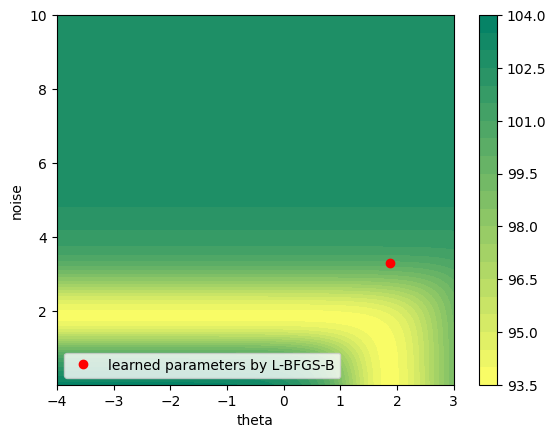

In [7]:
# plot the log_likelihood
fig, ax = plt.subplots()
cs = ax.contourf(theta, noise, log_likelihood_gpr,
                 levels=20, cmap=cm.summer_r)
ax.plot(theta_learned_gpr, noise_learned_gpr, "ro",
        label="learned parameters by L-BFGS-B")
# ax.plot(theta[idx], noise[idx], "b*", label="best parameters by grid search")
ax.legend(loc="lower left")
ax.set_xlabel("theta")
ax.set_ylabel("noise")
fig.colorbar(cs)
# plt.savefig("log_likelihood_gpr.png", dpi=300, bbox_inches="tight")
# plt.savefig("log_likelihood_gpr.svg", dpi=300, bbox_inches="tight")
plt.show()

gpr:  [75.99224127]
gpr:  [[0.83598445]]
gpr:  3.299868730599765


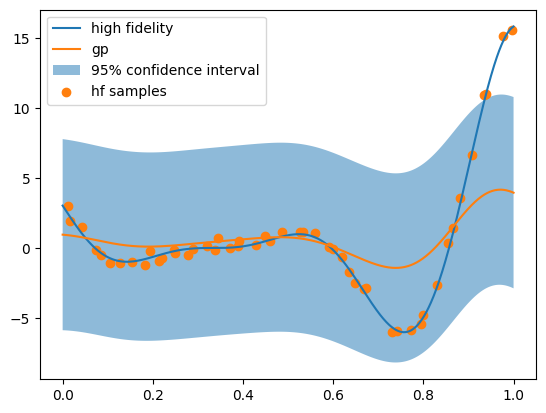

In [8]:
gpr_pred_y, gpr_pred_std = gpr.predict(x_predict=test_x, return_std=True)
print("gpr: ", gpr.kernel.param)
print("gpr: ", gpr.beta)
print("gpr: ", gpr.noise)
# plot
fig, ax = plt.subplots()
ax.plot(test_x, test_hy, label="high fidelity")
ax.plot(test_x, gpr_pred_y, label="gp")
ax.fill_between(
    test_x.flatten(),
    (gpr_pred_y - 1.96 * gpr_pred_std).flatten(),
    (gpr_pred_y + 1.96 * gpr_pred_std).flatten(),
    alpha=0.5,
    label="95% confidence interval",
)
ax.scatter(sample_x["hf"], sample_y_1a["hf"], label="hf samples")
ax.legend()
plt.show()

In [9]:
# for developed methods
start_time = time.time()
mfrbfgp1a = MFRBFGPR(
    design_space=func1a.input_domain, noise_prior=None, optimizer_restart=optimizer_restart
)
mfrbfgp1a.train(samples=sample_x, responses=sample_y_1a)
end_time = time.time()
mfrbfgp1a_time = end_time - start_time
print("mfrbfgp1a time: ", end_time - start_time)

mfrbfgp1a time:  4.329301357269287


In [10]:
#  generate the meshgrid for the parameters theta and noise
theta = np.linspace(-4, 3, 100)
noise = np.linspace(0.01, 10.0, 100)
theta, noise = np.meshgrid(theta, noise)
# calculate the log_likelihood
log_likelihood1a = np.zeros(theta.shape)
for i in range(theta.shape[0]):
    for j in range(theta.shape[1]):
        list_params = [theta[i, j], noise[i, j]]
        log_likelihood1a[i, j] = mfrbfgp1a._logLikelihood(params=list_params)

max_log_likelihood:  -7.3923765098439205
theta:  [-4.]
noise:  [0.01]


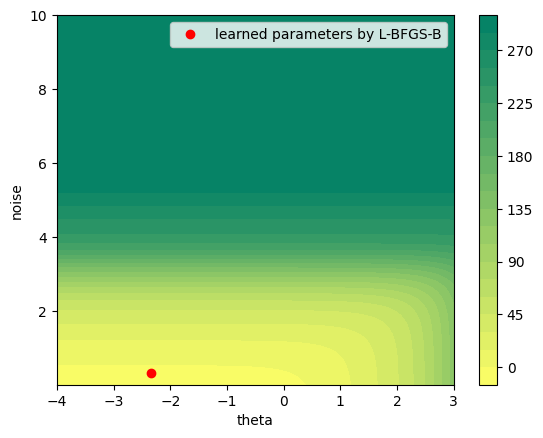

In [11]:
# find the maximum log_likelihood
min_log_likelihood = np.min(log_likelihood1a)
print("max_log_likelihood: ", min_log_likelihood)
# find the index of the maximum log_likelihood
idx = np.where(log_likelihood1a == min_log_likelihood)
print("theta: ", theta[idx])
print("noise: ", noise[idx])
# plot the log_likelihood
fig, ax = plt.subplots()
cs = ax.contourf(theta, noise, log_likelihood1a, levels=20, cmap=cm.summer_r)
ax.plot(
    np.log10(mfrbfgp1a.kernel.param[0]),
    mfrbfgp1a.noise,
    "ro",
    label="learned parameters by L-BFGS-B",
)
# ax.plot(theta[idx], noise[idx], "b*", label="best parameters by grid search")
ax.legend(loc="best")
ax.set_xlabel("theta")
ax.set_ylabel("noise")
fig.colorbar(cs)
# plt.savefig("mf_log_likelihood_1a.png", dpi=300, bbox_inches="tight")
plt.show()

mfrbfgp1a:  [0.00450853]
mfrbfgp1a:  [[1.00762909]]
mfrbfgp1a:  0.3255066059703692


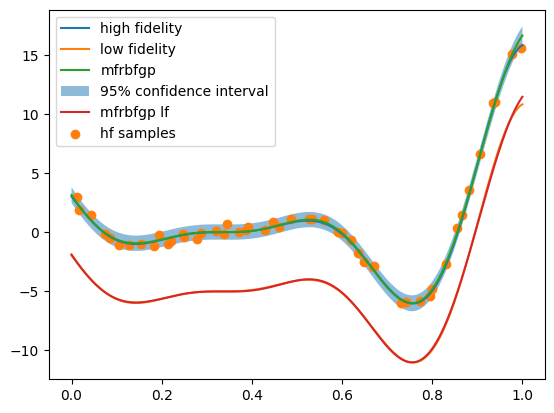

In [12]:
mfrbfgp_pred_y_1a, mfrbfgp_pred_std_1a = mfrbfgp1a.predict(
    x_predict=test_x, return_std=True)
# get prediction of low fidelity
pred_ly1a = mfrbfgp1a.predict_lf(test_xl=test_x)

print("mfrbfgp1a: ", mfrbfgp1a.kernel.param)
print("mfrbfgp1a: ", mfrbfgp1a.beta)
print("mfrbfgp1a: ", mfrbfgp1a.noise)
# plot
fig, ax = plt.subplots()
ax.plot(test_x, test_hy, label="high fidelity")
ax.plot(test_x, test_ly_1a, label="low fidelity")
ax.plot(test_x, mfrbfgp_pred_y_1a, label="mfrbfgp")
ax.fill_between(
    test_x.flatten(),
    (mfrbfgp_pred_y_1a - 1.96 * mfrbfgp_pred_std_1a).flatten(),
    (mfrbfgp_pred_y_1a + 1.96 * mfrbfgp_pred_std_1a).flatten(),
    alpha=0.5,
    label="95% confidence interval",
)
ax.plot(test_x, pred_ly1a, label="mfrbfgp lf")
ax.scatter(sample_x["hf"], sample_y_1a["hf"], label="hf samples")
# ax.scatter(sample_x["lf"], sample_y_1a["lf"], label="lf samples")
ax.legend()
plt.show()

## function Forrester_1b

In [13]:
# define function
func1b = Forrester_1b()

sample_y_1b = {}
# get response
sample_y_1b["hf"] = func1b.hf(sample_x["hf"]) + np.random.normal(
    0, noise_add, size=sample_x["hf"].shape[0]
).reshape(-1, 1)
sample_y_1b["lf"] = func1b.lf(sample_x["lf"]) + np.random.normal(
    0, noise_add, size=sample_x["lf"].shape[0]
).reshape(-1, 1)

# test data
test_ly_1b = func1b.lf(test_x)

In [14]:
start_time = time.time()
mfrbfgp1b = MFRBFGPR(
    design_space=func1b.input_domain, noise_prior=None, optimizer_restart=optimizer_restart
)
mfrbfgp1b.train(samples=sample_x, responses=sample_y_1b)
end_time = time.time()
mfrbfgp1b_time = end_time - start_time
print("mfrbfgp1b time: ", end_time - start_time)

mfrbfgp1b time:  3.2479255199432373


In [15]:
#  generate the meshgrid for the parameters theta and noise
theta = np.linspace(-4, 3, 100)
noise = np.linspace(0.01, 10.0, 100)
theta, noise = np.meshgrid(theta, noise)
# calculate the log_likelihood
log_likelihood1b = np.zeros(theta.shape)
for i in range(theta.shape[0]):
    for j in range(theta.shape[1]):
        list_params = [theta[i, j], noise[i, j]]
        log_likelihood1b[i, j] = mfrbfgp1b._logLikelihood(params=list_params)

max_log_likelihood:  87.3047571362632
theta:  [1.37373737]
noise:  [1.62454545]


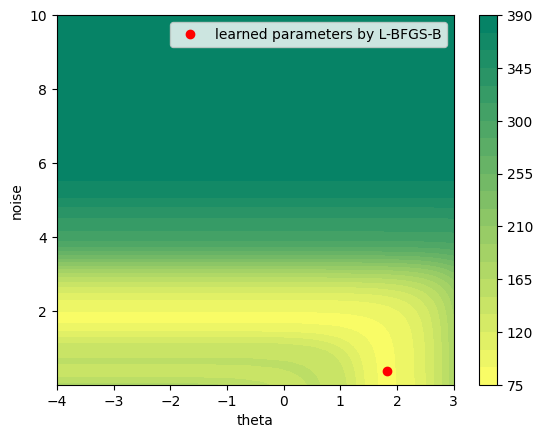

In [16]:
# find the maximum log_likelihood
min_log_likelihood = np.min(log_likelihood1b)
print("max_log_likelihood: ", min_log_likelihood)
# find the index of the maximum log_likelihood
idx = np.where(log_likelihood1b == min_log_likelihood)
print("theta: ", theta[idx])
print("noise: ", noise[idx])
# plot the log_likelihood
fig, ax = plt.subplots()
cs = ax.contourf(theta, noise, log_likelihood1b, levels=20, cmap=cm.summer_r)
ax.plot(
    np.log10(mfrbfgp1b.kernel.param[0]),
    mfrbfgp1b.noise,
    "ro",
    label="learned parameters by L-BFGS-B",
)
# ax.plot(theta[idx], noise[idx], "b*", label="best parameters by grid search")
ax.legend(loc="best")
ax.set_xlabel("theta")
ax.set_ylabel("noise")
fig.colorbar(cs)
# plt.savefig("mf_log_likelihood_1b.png", dpi=300, bbox_inches="tight")
plt.show()

mfrbfgp1b:  [65.7085806]
mfrbfgp1b:  [[0.52945299]]
mfrbfgp1b:  0.36833785985792533


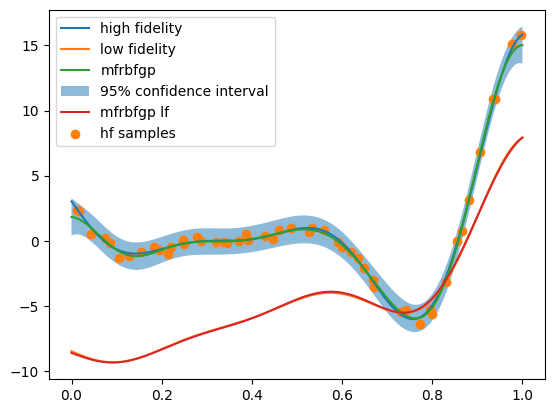

In [17]:

mfrbfgp_pred_y_1b, mfrbfgp_pred_std_1b = mfrbfgp1b.predict(
    x_predict=test_x, return_std=True)
# get prediction of low fidelity
pred_ly1b = mfrbfgp1b.predict_lf(test_xl=test_x)

print("mfrbfgp1b: ", mfrbfgp1b.kernel.param)
print("mfrbfgp1b: ", mfrbfgp1b.beta)
print("mfrbfgp1b: ", mfrbfgp1b.noise)
# plot
fig, ax = plt.subplots()
ax.plot(test_x, test_hy, label="high fidelity")
ax.plot(test_x, test_ly_1b, label="low fidelity")
ax.plot(test_x, mfrbfgp_pred_y_1b, label="mfrbfgp")
ax.fill_between(
    test_x.flatten(),
    (mfrbfgp_pred_y_1b - 1.96 * mfrbfgp_pred_std_1b).flatten(),
    (mfrbfgp_pred_y_1b + 1.96 * mfrbfgp_pred_std_1b).flatten(),
    alpha=0.5,
    label="95% confidence interval",
)
ax.plot(test_x, pred_ly1b, label="mfrbfgp lf")
ax.scatter(sample_x["hf"], sample_y_1b["hf"], label="hf samples")
# ax.scatter(sample_x["lf"], sample_y_1a["lf"], label="lf samples")
ax.legend()
plt.show()

## function Forrester 1c 


In [18]:
# define function
func1c = Forrester_1c()

sample_y_1c = {}
# get response
sample_y_1c["hf"] = func1c.hf(sample_x["hf"]) + np.random.normal(
    0, noise_add, size=sample_x["hf"].shape[0]
).reshape(-1, 1)
sample_y_1c["lf"] = func1c.lf(sample_x["lf"]) + np.random.normal(
    0, noise_add, size=sample_x["lf"].shape[0]
).reshape(-1, 1)

# test data
test_ly_1c = func1c.lf(test_x)

In [19]:
start_time = time.time()
mfrbfgp1c = MFRBFGPR(
    design_space=func1c.input_domain, noise_prior=None, optimizer_restart=optimizer_restart
)
mfrbfgp1c.train(samples=sample_x, responses=sample_y_1c)
end_time = time.time()
mfrbfgp1c_time = end_time - start_time
print("mfrbfgp1c time: ", end_time - start_time)

mfrbfgp1c time:  6.13224458694458


In [20]:
#  generate the meshgrid for the parameters theta and noise
theta = np.linspace(-4, 3, 100)
noise = np.linspace(0.01, 10.0, 100)
theta, noise = np.meshgrid(theta, noise)
# calculate the log_likelihood
log_likelihood1c = np.zeros(theta.shape)
for i in range(theta.shape[0]):
    for j in range(theta.shape[1]):
        list_params = [theta[i, j], noise[i, j]]
        log_likelihood1c[i, j] = mfrbfgp1c._logLikelihood(params=list_params)

max_log_likelihood:  15.970317747106236
theta:  [1.72727273]
noise:  [0.81727273]


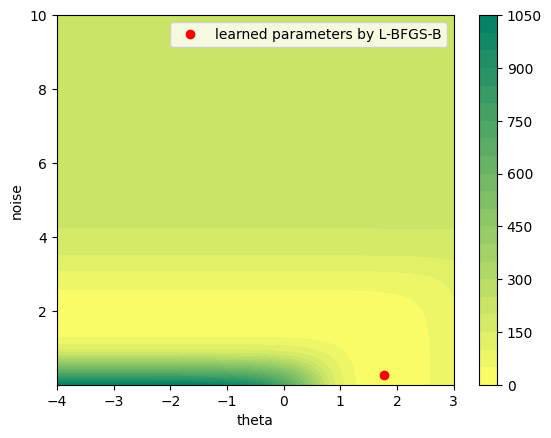

In [21]:
# find the maximum log_likelihood
min_log_likelihood = np.min(log_likelihood1c)
print("max_log_likelihood: ", min_log_likelihood)
# find the index of the maximum log_likelihood
idx = np.where(log_likelihood1c == min_log_likelihood)
print("theta: ", theta[idx])
print("noise: ", noise[idx])
# plot the log_likelihood
fig, ax = plt.subplots()
cs = ax.contourf(theta, noise, log_likelihood1c, levels=20, cmap=cm.summer_r)
ax.plot(
    np.log10(mfrbfgp1c.kernel.param[0]),
    mfrbfgp1c.noise,
    "ro",
    label="learned parameters by L-BFGS-B",
)
# ax.plot(theta[idx], noise[idx], "b*", label="best parameters by grid search")
ax.legend(loc="best")
ax.set_xlabel("theta")
ax.set_ylabel("noise")
fig.colorbar(cs)
# plt.savefig("mf_log_likelihood_1c.png", dpi=300, bbox_inches="tight")
plt.show()

mfrbfgp1c:  [59.76408238]
mfrbfgp1c:  [[-0.46143159]]
mfrbfgp1c:  0.27506543186619153


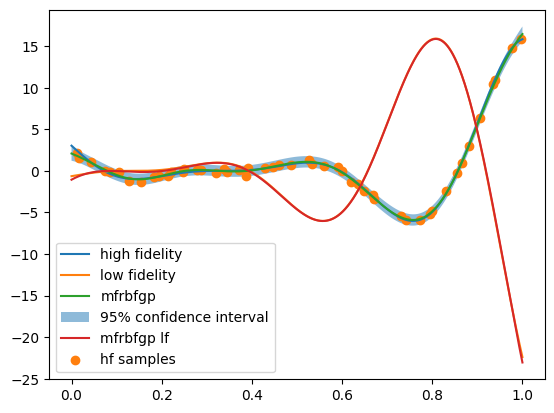

In [22]:

mfrbfgp_pred_y_1c, mfrbfgp_pred_std_1c = mfrbfgp1c.predict(
    x_predict=test_x, return_std=True)
# get prediction of low fidelity
pred_ly1c = mfrbfgp1c.predict_lf(test_xl=test_x)

print("mfrbfgp1c: ", mfrbfgp1c.kernel.param)
print("mfrbfgp1c: ", mfrbfgp1c.beta)
print("mfrbfgp1c: ", mfrbfgp1c.noise)
# plot
fig, ax = plt.subplots()
ax.plot(test_x, test_hy, label="high fidelity")
ax.plot(test_x, test_ly_1c, label="low fidelity")
ax.plot(test_x, mfrbfgp_pred_y_1c, label="mfrbfgp")
ax.fill_between(
    test_x.flatten(),
    (mfrbfgp_pred_y_1c - 1.96 * mfrbfgp_pred_std_1c).flatten(),
    (mfrbfgp_pred_y_1c + 1.96 * mfrbfgp_pred_std_1c).flatten(),
    alpha=0.5,
    label="95% confidence interval",
)
ax.plot(test_x, pred_ly1c, label="mfrbfgp lf")
ax.scatter(sample_x["hf"], sample_y_1c["hf"], label="hf samples")
# ax.scatter(sample_x["lf"], sample_y_1a["lf"], label="lf samples")
ax.legend()
plt.show()

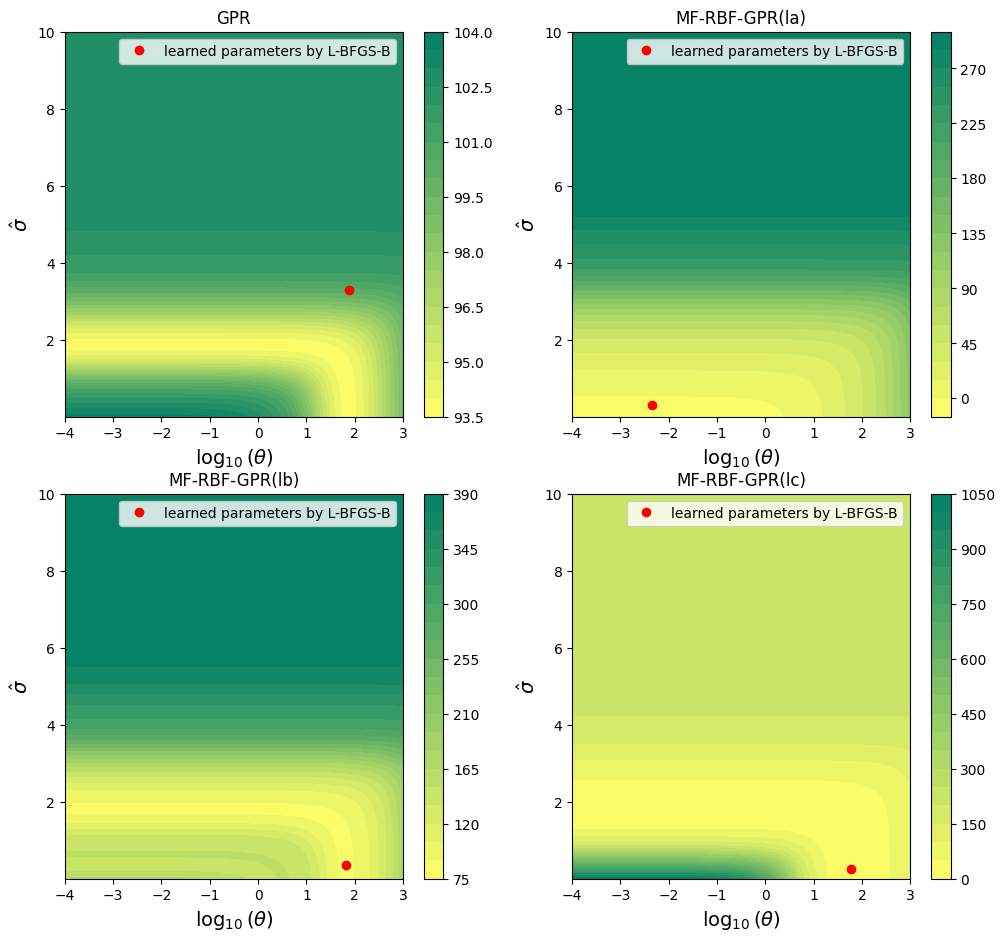

In [23]:
# plot the land scape of  log_likelihood function for all three functions and gpr method

fig, ax = plt.subplots(2, 2, figsize=(12, 11))
# plot the log_likelihood
cs = ax[0, 0].contourf(theta, noise, log_likelihood_gpr,
                       levels=20, cmap=cm.summer_r)
ax[0, 0].plot(theta_learned_gpr, noise_learned_gpr, "ro",
              label="learned parameters by L-BFGS-B")
ax[0, 0].legend(loc="best")
ax[0, 0].set_xlabel(r"$\log_{10}(\theta)$", fontsize=14)
ax[0, 0].set_ylabel(r"$\hat{\sigma}$", fontsize=14)
ax[0, 0].set_title("GPR")
fig.colorbar(cs)
# plot the log_likelihood
cs = ax[0, 1].contourf(theta, noise, log_likelihood1a,
                       levels=20, cmap=cm.summer_r)
ax[0, 1].plot(np.log10(mfrbfgp1a.kernel.param[0]),
              mfrbfgp1a.noise,
              "ro",
              label="learned parameters by L-BFGS-B",
              )
ax[0, 1].legend(loc="best")
ax[0, 1].set_xlabel(r"$\log_{10}(\theta)$", fontsize=14)
ax[0, 1].set_ylabel(r"$\hat{\sigma}$", fontsize=14)
ax[0, 1].set_title("MF-RBF-GPR(la)")
fig.colorbar(cs)
# plot the log_likelihood
cs = ax[1, 0].contourf(theta, noise, log_likelihood1b,
                       levels=20, cmap=cm.summer_r)
ax[1, 0].plot(
    np.log10(mfrbfgp1b.kernel.param[0]),
    mfrbfgp1b.noise,
    "ro",
    label="learned parameters by L-BFGS-B",
)
ax[1, 0].legend(loc="best")
ax[1, 0].set_xlabel(r"$\log_{10}(\theta)$", fontsize=14)
ax[1, 0].set_ylabel(r"$\hat{\sigma}$", fontsize=14)
ax[1, 0].set_title("MF-RBF-GPR(lb)")
fig.colorbar(cs)
# plot the log_likelihood
cs = ax[1, 1].contourf(theta, noise, log_likelihood1c,
                       levels=20, cmap=cm.summer_r)
ax[1, 1].plot(
    np.log10(mfrbfgp1c.kernel.param[0]),
    mfrbfgp1c.noise,
    "ro",
    label="learned parameters by L-BFGS-B",
)
ax[1, 1].legend(loc="best")
ax[1, 1].set_xlabel(r"$\log_{10}(\theta)$", fontsize=14)
ax[1, 1].set_ylabel(r"$\hat{\sigma}$", fontsize=14)
ax[1, 1].set_title("MF-RBF-GPR(lc)")
fig.colorbar(cs)
plt.savefig("neg_log_likelihood_comparison.png", dpi=300, bbox_inches="tight")
plt.savefig("neg_log_likelihood_comparison.svg", dpi=300, bbox_inches="tight")
plt.savefig("neg_log_likelihood_comparison.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [24]:
# output the learned parameters
print("gpr theta: ", gpr.kernel.param)
print("gpr beta: ", gpr.beta)
print("gpr noise: ", gpr.noise)
print("mfrbfgp1a theta: ", mfrbfgp1a.kernel.param)
print("mfrbfgp1a beta: ", mfrbfgp1a.beta)
print("mfrbfgp1a noise: ", mfrbfgp1a.noise)
print("mfrbfgp1b theta: ", mfrbfgp1b.kernel.param)
print("mfrbfgp1b beta: ", mfrbfgp1b.beta)
print("mfrbfgp1b noise: ", mfrbfgp1b.noise)
print("mfrbfgp1c theta: ", mfrbfgp1c.kernel.param)
print("mfrbfgp1c beta: ", mfrbfgp1c.beta)
print("mfrbfgp1c noise: ", mfrbfgp1c.noise)

gpr theta:  [75.99224127]
gpr beta:  [[0.83598445]]
gpr noise:  3.299868730599765
mfrbfgp1a theta:  [0.00450853]
mfrbfgp1a beta:  [[1.00762909]]
mfrbfgp1a noise:  0.3255066059703692
mfrbfgp1b theta:  [65.7085806]
mfrbfgp1b beta:  [[0.52945299]]
mfrbfgp1b noise:  0.36833785985792533
mfrbfgp1c theta:  [59.76408238]
mfrbfgp1c beta:  [[-0.46143159]]
mfrbfgp1c noise:  0.27506543186619153


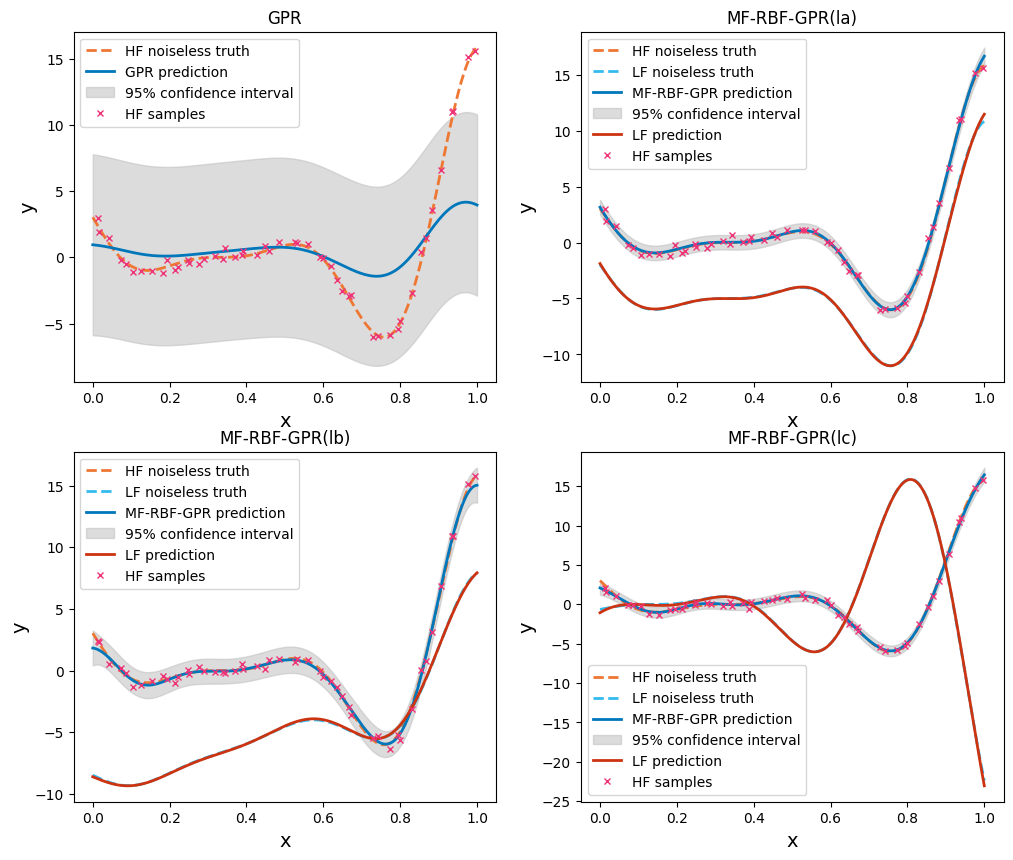

In [25]:
# plot the prediction
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(test_x, test_hy, "--", color="#EE7733",
              linewidth=2, label="HF noiseless truth")
ax[0, 0].plot(test_x, gpr_pred_y, "-", color="#0077BB",
              linewidth=2, label="GPR prediction")
ax[0, 0].fill_between(
    test_x.flatten(),
    (gpr_pred_y - 1.96 * gpr_pred_std).flatten(),
    (gpr_pred_y + 1.96 * gpr_pred_std).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="95% confidence interval",
)
ax[0, 0].plot(sample_x["hf"], sample_y_1a["hf"],
              "x",
              color="#EE3377",
              linewidth=2,
              markersize=5,
              label="HF samples",)
ax[0, 0].set_xlabel("x", fontsize=14)
ax[0, 0].set_ylabel("y", fontsize=14)
ax[0, 0].legend()
ax[0, 0].set_title("GPR")
ax[0, 1].plot(test_x, test_hy, "--", color="#EE7733",
              linewidth=2, label="HF noiseless truth")
ax[0, 1].plot(test_x, test_ly_1a, "--", color="#33BBEE",
              linewidth=2, label="LF noiseless truth")
ax[0, 1].plot(test_x, mfrbfgp_pred_y_1a, "-", color="#0077BB",
              linewidth=2, label="MF-RBF-GPR prediction")
ax[0, 1].fill_between(
    test_x.flatten(),
    (mfrbfgp_pred_y_1a - 1.96 * mfrbfgp_pred_std_1a).flatten(),
    (mfrbfgp_pred_y_1a + 1.96 * mfrbfgp_pred_std_1a).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="95% confidence interval",
)
ax[0, 1].plot(test_x, pred_ly1a, "-", color="#CC3311",
              linewidth=2, label="LF prediction")
ax[0, 1].plot(sample_x["hf"], sample_y_1a["hf"],
              "x",
              color="#EE3377",
              linewidth=2,
              markersize=5,
              label="HF samples",)
ax[0, 1].set_xlabel("x", fontsize=14)
ax[0, 1].set_ylabel("y", fontsize=14)
ax[0, 1].legend()
ax[0, 1].set_title("MF-RBF-GPR(la)")
ax[1, 0].plot(test_x, test_hy, "--", color="#EE7733",
              linewidth=2, label="HF noiseless truth")
ax[1, 0].plot(test_x, test_ly_1b, "--", color="#33BBEE",
              linewidth=2, label="LF noiseless truth")
ax[1, 0].plot(test_x, mfrbfgp_pred_y_1b, "-", color="#0077BB",
              linewidth=2, label="MF-RBF-GPR prediction")
ax[1, 0].fill_between(
    test_x.flatten(),
    (mfrbfgp_pred_y_1b - 1.96 * mfrbfgp_pred_std_1b).flatten(),
    (mfrbfgp_pred_y_1b + 1.96 * mfrbfgp_pred_std_1b).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="95% confidence interval",
)
ax[1, 0].plot(test_x, pred_ly1b, "-", color="#CC3311",
              linewidth=2, label="LF prediction")
ax[1, 0].plot(sample_x["hf"], sample_y_1b["hf"], "x",
              color="#EE3377",
              linewidth=2,
              markersize=5,
              label="HF samples",)
ax[1, 0].set_xlabel("x", fontsize=14)
ax[1, 0].set_ylabel("y", fontsize=14)
ax[1, 0].legend()
ax[1, 0].set_title("MF-RBF-GPR(lb)")
ax[1, 1].plot(test_x, test_hy, "--", color="#EE7733",
              linewidth=2, label="HF noiseless truth")
ax[1, 1].plot(test_x, test_ly_1c, "--", color="#33BBEE",
              linewidth=2, label="LF noiseless truth")
ax[1, 1].plot(test_x, mfrbfgp_pred_y_1c, "-", color="#0077BB",
              linewidth=2, label="MF-RBF-GPR prediction")
ax[1, 1].fill_between(
    test_x.flatten(),
    (mfrbfgp_pred_y_1c - 1.96 * mfrbfgp_pred_std_1c).flatten(),
    (mfrbfgp_pred_y_1c + 1.96 * mfrbfgp_pred_std_1c).flatten(),
    alpha=0.5,
    color="#BBBBBB",
    label="95% confidence interval",
)
ax[1, 1].plot(test_x, pred_ly1c, "-", color="#CC3311",
              linewidth=2, label="LF prediction")
ax[1, 1].plot(sample_x["hf"], sample_y_1c["hf"], "x",
              color="#EE3377",
              linewidth=2,
              markersize=5,
              label="HF samples",)
ax[1, 1].set_xlabel("x", fontsize=14)
ax[1, 1].set_ylabel("y", fontsize=14)
ax[1, 1].legend()
ax[1, 1].set_title("MF-RBF-GPR(lc)")
plt.savefig("prediction_comparison.png", dpi=300, bbox_inches="tight")
plt.savefig("prediction_comparison.svg", dpi=300, bbox_inches="tight")
plt.savefig("prediction_comparison.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [29]:
# calculate the rmse, mae, r2 score and nll for all three functions
# gpr
import pandas as pd
gpr_rmse = mean_squared_error(test_hy, gpr_pred_y)
gpr_mae = mean_absolute_error(test_hy, gpr_pred_y)
gpr_r2 = r2_score(test_hy, gpr_pred_y)
gpr_nll = calculate_log_marginal_likelihood_gpr(gpr, test_x, test_hy_noisy)
# print("gpr_rmse: ", gpr_rmse)
# print("gpr_mae: ", gpr_mae)
# print("gpr_r2: ", gpr_r2)
# print("gpr_nll: ", gpr_nll)

# mfrbfgp1a
mfrbfgp1a_rmse = mean_squared_error(test_hy, mfrbfgp_pred_y_1a)
mfrbfgp1a_mae = mean_absolute_error(test_hy, mfrbfgp_pred_y_1a)
mfrbfgp1a_r2 = r2_score(test_hy, mfrbfgp_pred_y_1a)
mfrbfgp1a_nll = calculate_log_marginal_likelihood_mf(
    mfrbfgp1a, test_x, test_hy_noisy)
# print("mfrbfgp1a_rmse: ", mfrbfgp1a_rmse)
# print("mfrbfgp1a_mae: ", mfrbfgp1a_mae)
# print("mfrbfgp1a_r2: ", mfrbfgp1a_r2)
# print("mfrbfgp1a_nll: ", mfrbfgp1a_nll)

# mfrbfgp1b
mfrbfgp1b_rmse = mean_squared_error(test_hy, mfrbfgp_pred_y_1b)
mfrbfgp1b_mae = mean_absolute_error(test_hy, mfrbfgp_pred_y_1b)
mfrbfgp1b_r2 = r2_score(test_hy, mfrbfgp_pred_y_1b)
mfrbfgp1b_nll = calculate_log_marginal_likelihood_mf(
    mfrbfgp1b, test_x, test_hy_noisy)
# print("mfrbfgp1b_rmse: ", mfrbfgp1b_rmse)
# print("mfrbfgp1b_mae: ", mfrbfgp1b_mae)
# print("mfrbfgp1b_r2: ", mfrbfgp1b_r2)
# print("mfrbfgp1b_nll: ", mfrbfgp1b_nll)

# mfrbfgp1c
mfrbfgp1c_rmse = mean_squared_error(test_hy, mfrbfgp_pred_y_1c)
mfrbfgp1c_mae = mean_absolute_error(test_hy, mfrbfgp_pred_y_1c)
mfrbfgp1c_r2 = r2_score(test_hy, mfrbfgp_pred_y_1c)
mfrbfgp1c_nll = calculate_log_marginal_likelihood_mf(
    mfrbfgp1c, test_x, test_hy_noisy)

# print("mfrbfgp1c_rmse: ", mfrbfgp1c_rmse)
# print("mfrbfgp1c_mae: ", mfrbfgp1c_mae)
# print("mfrbfgp1c_r2: ", mfrbfgp1c_r2)
# print("mfrbfgp1c_nll: ", mfrbfgp1c_nll)

# save all those results to pandas dataframe
# create a dictionary
data = {
    "mse": [gpr_rmse, mfrbfgp1a_rmse, mfrbfgp1b_rmse, mfrbfgp1c_rmse],
    "mae": [gpr_mae, mfrbfgp1a_mae, mfrbfgp1b_mae, mfrbfgp1c_mae],
    "r2": [gpr_r2, mfrbfgp1a_r2, mfrbfgp1b_r2, mfrbfgp1c_r2],
    "nll": [gpr_nll, mfrbfgp1a_nll, mfrbfgp1b_nll, mfrbfgp1c_nll],
    "cpu_time": [gpr_time, mfrbfgp1a_time, mfrbfgp1b_time, mfrbfgp1c_time],
    "noise": [gpr.noise, mfrbfgp1a.noise, mfrbfgp1b.noise, mfrbfgp1c.noise],
    "beta": [gpr.beta, mfrbfgp1a.beta, mfrbfgp1b.beta, mfrbfgp1c.beta],
}
# create a dataframe
df = pd.DataFrame(data, index=["gpr", "mfrbfgp1a", "mfrbfgp1b", "mfrbfgp1c"])
print(df)

# save the dataframe to csv file
df.to_csv("comparison.csv")

                 mse       mae        r2          nll  cpu_time     noise  \
gpr        10.293579  1.942676  0.484274 -1318.423378  2.239611  3.299869   
mfrbfgp1a   0.010985  0.060982  0.999450   675.003950  4.329301  0.325507   
mfrbfgp1b   0.038319  0.127419  0.998080   535.732139  3.247926  0.368338   
mfrbfgp1c   0.028964  0.115870  0.998549   645.533124  6.132245  0.275065   

                              beta  
gpr         [[0.8359844487135076]]  
mfrbfgp1a   [[1.0076290881183914]]  
mfrbfgp1b   [[0.5294529906922372]]  
mfrbfgp1c  [[-0.4614315859831273]]  
